In [1]:
import os
import sys
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

root_dir = "../"
sys.path.append(root_dir)
import configs
from ibydmt.utils.config import get_config
from ibydmt.testing.procedure import SKIT, cSKIT, xSKIT
from synthetic_lib import sample, cond_p, model

config_name = "synthetic"

linear_config = get_config(config_name)
linear_config.testing.kernel = "linear"

rbf_config = get_config(config_name)
rbf_config.testing.kernel = "rbf"
rbf_config.testing.kernel_scale_method = "quantile"
rbf_config.testing.kernel_scale = 0.5

figure_dir = os.path.join(root_dir, "figures", "synthetic")
os.makedirs(figure_dir, exist_ok=True)

sns.set_style("white")
sns.set_context("paper")

d:\IBYDMT_proj\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


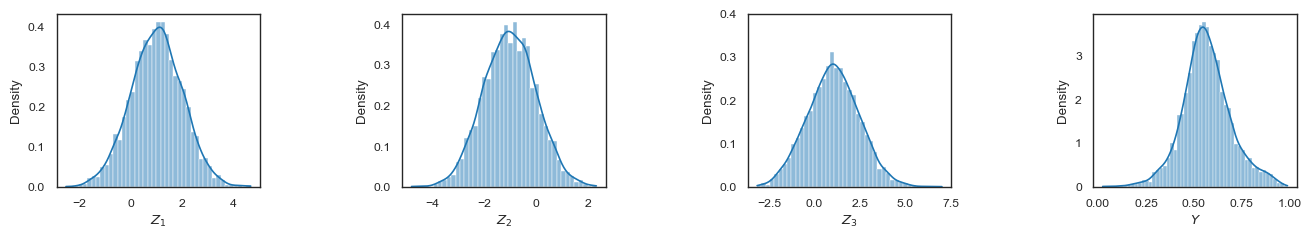

In [2]:
beta = 0.3 * np.ones(3)
Z, Y = sample(int(4e03), beta=beta)

d = Z.shape[1]
_, axes = plt.subplots(1, d + 1, figsize=(16, 9 / 4), gridspec_kw={"wspace": 0.7})
for j in range(d):
    ax = axes[j]
    sns.histplot(x=Z[:, j], ax=ax, kde=True, stat="density")
    ax.set_xlabel(f"$Z_{j+1}$")
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])

ax = axes[-1]
sns.histplot(x=Y, ax=ax, kde=True, stat="density")
ax.set_xlabel(r"$Y$")
plt.savefig(os.path.join(figure_dir, "data.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "data.png"), bbox_inches="tight")
plt.show()

In [3]:
assert linear_config.testing.tau_max == rbf_config.testing.tau_max
tau_max = linear_config.testing.tau_max

assert linear_config.testing.r == rbf_config.testing.r
r = linear_config.testing.r

assert linear_config.testing.significance_level == rbf_config.testing.significance_level
significance_level = linear_config.testing.significance_level

num, m = 11, 0.2
betas = np.linspace(0, m, num)
z3s = np.linspace(-m / 2, m / 2, num)


def test_beta2(b, config):
    _beta = beta.copy()
    _beta[1] = b

    rej_hist, tau_hist = [], []
    for _ in tqdm(range(r)):
        Z, Y = sample(int(2 * tau_max), beta=_beta)
        Z2 = Z[:, 1]

        tester = SKIT(config, Y, Z2)
        rejected, tau = tester.test()

        rej_hist.append(rejected)
        tau_hist.append(tau)

    return np.mean(rej_hist), np.mean(tau_hist)


def test_beta1(b, config):
    _beta = beta.copy()
    _beta[0] = b

    rej_hist, tau_hist = [], []
    for _ in tqdm(range(r)):
        Z, Y = sample(int(tau_max), beta=_beta)

        tester = cSKIT(config, Y, Z, 0, cond_p)
        rejected, tau = tester.test()

        rej_hist.append(rejected)
        tau_hist.append(tau)

    return np.mean(rej_hist), np.mean(tau_hist)


def test_z3(z3, config, model):
    z = cond_p(np.array([None, 1, z3]), [1, 2]).squeeze()

    rej_hist, tau_hist = [], []
    for _ in tqdm(range(r)):
        tester = xSKIT(
            config,
            z,
            1,
            [2],
            cond_p,
            model,
            cond_p_kwargs=dict(m=config.testing.tau_max),
        )
        rejected, tau = tester.test()

        rej_hist.append(rejected)
        tau_hist.append(tau)

    return np.mean(rej_hist), np.mean(tau_hist)


def viz_results(u, results, name, color, ax):
    rejected, tau = zip(*results)
    normalized_tau = [t / tau_max for t in tau]

    ax.plot(u, rejected, c=color, marker="o", label=f"Rejection rate ({name})")
    ax.plot(
        u,
        normalized_tau,
        c=color,
        marker="o",
        linestyle="--",
        alpha=0.6,
        label=f"Rejection time ({name})",
    )

In [ ]:
results_linear_beta2 = Parallel(n_jobs=-1)(
    delayed(test_beta2)(b, linear_config) for b in betas
)
results_rbf_beta2 = Parallel(n_jobs=-1)(
    delayed(test_beta2)(b, rbf_config) for b in betas
)

In [ ]:
assert linear_config.testing.significance_level == rbf_config.testing.significance_level
significance_level = linear_config.testing.significance_level

global_null_beta = beta.copy()
global_null_beta[1] = 0

null_Z, null_Y = sample(int(4e03), beta=global_null_beta)

z2, null_z2 = Z[:, 1], null_Z[:, 1]

_, axes = plt.subplots(
    1,
    3,
    figsize=(16 / 1.5, 9 / 4),
    width_ratios=[1, 1, 1.5],
    gridspec_kw={"wspace": 0.5},
)
ax = axes[0]
sns.regplot(
    x=z2,
    y=Y,
    ax=ax,
    scatter_kws={"alpha": 0.2, "s": 4},
    line_kws={"color": "red", "linestyle": "--", "linewidth": 1},
)
ax.set_xlabel(r"$Z_2$")
ax.set_ylabel(r"$Y$")
ax.set_ylim(0, 1.1)
ax.set_xticks([-4, -2, 0, 2])
ax.set_title(r"$\beta_2 = 1$")

ax = axes[1]
sns.regplot(
    x=null_z2,
    y=null_Y,
    ax=ax,
    scatter_kws={"alpha": 0.2, "s": 4},
    line_kws={"color": "red", "linestyle": "--", "linewidth": 1},
)
ax.set_xlabel(r"$Z_2$")
ax.set_ylabel(r"$Y$")
ax.set_ylim(0, 1.1)
ax.set_title(r"$\beta_2 = 0$")


ax = axes[2]
viz_results(betas, results_linear_beta2, "linear", "lightblue", ax)
viz_results(betas, results_rbf_beta2, "rbf", "lightcoral", ax)
ax.axhline(
    significance_level, c="black", linestyle="--", alpha=0.5, label="Significance level"
)
ax.set_xlabel(r"$\beta_2$")
ax.set_title(r"$Y \perp \!\!\!\!\! \perp Z_2$")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(figure_dir, "global.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "global.png"), bbox_inches="tight")
plt.show()

In [ ]:
results_linear_beta1 = Parallel(n_jobs=-1)(
    delayed(test_beta1)(b, linear_config) for b in betas
)
results_rbf_beta1 = Parallel(n_jobs=-1)(
    delayed(test_beta1)(b, rbf_config) for b in betas
)

In [ ]:
z = np.array([[0.5, -1, 3]])
z = np.tile(z, (4000, 1))
y = model(z, beta=beta) + np.random.normal(0, 0.01, size=4000)

null_z = cond_p(z, [1, 2])

z1, null_z1 = z[:, 0], null_z[:, 0]

_, axes = plt.subplots(
    1,
    3,
    figsize=(16 / 1.5, 9 / 4),
    width_ratios=[1, 1, 1.5],
    gridspec_kw={"wspace": 0.5},
)
ax = axes[0]
sns.scatterplot(x=z1, y=y, ax=ax, alpha=0.2)
ax.set_xlabel(r"$Z_1$")
ax.set_ylabel(r"$Y$")
ax.set_title(r"$P_{YZ_{1}Z_{-1}}$")

ax = axes[1]
sns.regplot(
    x=null_z1,
    y=y,
    ax=ax,
    scatter_kws={"alpha": 0.2, "s": 4},
    line_kws={"color": "red", "linestyle": "--", "linewidth": 1},
)
ax.set_xlabel(r"$\widetilde{Z}_1$")
ax.set_ylabel(r"$Y$")
ax.set_title(r"$(Y,Z_1) \mid Z_{-1} = [-1, 3]$")

ax = axes[2]
viz_results(betas, results_linear_beta1, "linear", "lightblue", ax)
viz_results(betas, results_rbf_beta1, "rbf", "lightcoral", ax)
ax.axhline(
    significance_level, c="black", linestyle="--", alpha=0.5, label="Significance level"
)
ax.set_xlabel(r"$\beta_1$")
ax.set_title(r"$Y \perp \!\!\!\!\! \perp Z_1 \mid Z_{-1}$")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(figure_dir, "global_cond.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "global_cond.png"), bbox_inches="tight")
plt.show()

In [ ]:
_model = lambda x: model(x, beta=beta)[:, None]

results_linear_z3 = Parallel(n_jobs=-1)(
    delayed(test_z3)(z3, linear_config, _model) for z3 in z3s
)
results_rbf_z3 = Parallel(n_jobs=-1)(
    delayed(test_z3)(z3, rbf_config, _model) for z3 in z3s
)

In [ ]:
_, axes = plt.subplots(
    1,
    3,
    figsize=(16 / 1.5, 9 / 4),
    width_ratios=[1, 1, 1.5],
    gridspec_kw={"wspace": 0.5},
)
for i, z3 in enumerate([0.5, 0.0]):
    z = cond_p(np.array([[None, 3.0, z3]]), [1, 2])

    cond_z = cond_p(np.tile(z, (1000, 1)), [1, 2])
    null_z = cond_p(np.tile(z, (1000, 1)), [2])

    y, null_y = _model(cond_z).squeeze(), _model(null_z).squeeze()

    ax = axes[i]
    sns.histplot(
        x=y,
        kde=True,
        color="lightblue",
        alpha=0.5,
        stat="density",
        ax=ax,
        label=r"$g(\widetilde{Z}_{\{2,3\}})$",
    )
    sns.histplot(
        x=null_y,
        kde=True,
        color="lightcoral",
        alpha=0.5,
        stat="density",
        ax=ax,
        label=r"$g(\widetilde{Z}_{3})$",
    )

    ax.set_xlabel(r"$g(Z)$")
    ax.set_xlim(0.25, 0.85)
    ax.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    ax.set_title(r"$Z_2 = 1,~Z_3 = {%.2f}$" % z3)
    ax.legend()


ax = axes[-1]
viz_results(z3s, results_linear_z3, "linear", "lightblue", ax)
viz_results(z3s, results_rbf_z3, "rbf", "lightcoral", ax)
ax.axhline(
    significance_level, c="black", linestyle="--", alpha=0.5, label="Significance level"
)
ax.set_xlabel(r"$z_3$")
ax.set_title(r"$g(\widetilde{Z}_{2,3}) \overset{d}{=} g(\widetilde{Z}_3)$")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(figure_dir, "local_cond.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "local_cond.png"), bbox_inches="tight")
plt.show()